In [1]:
import imgtda
from imgtda import standard_analysis as sa
from imgtda import computer_vision as cv

import numpy as np
import pandas as pd
from scipy import misc
from skimage import morphology as morph
from skimage import measure
import scipy
from scipy import ndimage as ndi
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pprint as pp

## Set Up Project

In [2]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_format':'g21per/bmps_abs_val/%05d.bmp',
                                'delta':10,
                                'lyap_stats_plots_out':'g21flow/independence_analysis/2017_11_18_pr_curves/'}


## Utility Functions

In [3]:
def load_image_data(project, idx):
    
    im = imgtda.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    return im

def load_lyap_data(project, idx):
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_format'] % idx))
    return lyap

def load_lyap_pd_data(project, idx):
    
    lyap = pd.DataFrame(pd.read_csv(project['directory'] + "/" + (project['additional_data']['lyap_pdsub_format'] % idx)))
    return lyap

def cropping_region():

    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)
    return c


def get_image_saddle_points(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_saddles = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==0) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']>=lowercutoff) & (im.persistence_diagrams['sub']['death']<=127)][['d_x','d_y']]
    ph_lower_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['birth']>=lowercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_lower_saddles = pd.concat([ph_lower_saddles, ph_tmp])

    ph_upper_saddles = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==0) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['death']>=127) & (im.persistence_diagrams['sup']['death']<=uppercutoff)][['d_x','d_y']]
    ph_upper_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['birth']<=uppercutoff)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_upper_saddles = pd.concat([ph_upper_saddles, ph_tmp])
    
    saddle_points = pd.concat([ph_lower_saddles, ph_upper_saddles])
    
    saddle_matrix = np.zeros(im.bmp.shape)
    saddle_matrix[saddle_points['row'], saddle_points['col']] = 1

    return saddle_matrix


def get_image_plumes(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_plumes = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']<=uppercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['d_x','d_y']]
    ph_lower_plumes.columns = ['col', 'row']

    ph_upper_plumes = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['death']>=lowercutoff)][['d_x','d_y']]
    ph_upper_plumes.columns = ['col', 'row']
    
    plumes = pd.concat([ph_lower_plumes, ph_upper_plumes])
    
    plume_matrix = np.zeros(im.bmp.shape)
    plume_matrix[plumes['row'], plumes['col']] = 1

    return plume_matrix

def get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta):

    im = load_image_data(myproject, idx)
    
    im.generate_orientation_field(sigma,1)
    im.orientation_fields[sigma].topological_defects_list = sa.topological_defect_array_to_dataframe(im.orientation_fields[sigma].topological_defects)
    im.saddle_points = get_image_saddle_points(im, lowercutoff, uppercutoff, delta)
    im.plumes = get_image_plumes(im, lowercutoff, uppercutoff, delta)

    return im



## Preprocess data for animation

### Functions for processing

In [4]:
def get_td_velocities(current, prior, distance_cutoff):
    
    types = [1., -1.]
    
    current['velocity'] = distance_cutoff
    current['matchedid'] = -1
    

    if not prior.empty:
        for t in types:
            type_matches = cv.match_points(current.ix[current.type == t,['row', 'col']], prior.loc[prior.type == t,['row', 'col']], distance_cutoff)
            current.ix[current.type==t, 'velocity'] = type_matches[:,1]
            current.ix[current.type==t, 'matchedid'] = type_matches[:,0].astype(np.int)
            
    return current

def compose(f, x, n):
    if n == 0:
        return x
    return compose(f, f(x), n - 1)

def log_plus_one(x):
    return np.log10(10.*x+1)

def get_independence_values(A, B, area):
    p_AB = float(np.sum(np.multiply(A, B)))/area
    p_A = float(np.sum(A))/area
    p_B = float(np.sum(B))/area
    
    return (p_AB, p_A, p_B)
    
    
def compute_derivative(images, derivative):
    if derivative == 1:
        return abs(images[0] - images[1])  
    else: 
        return compute_derivative([compute_derivative(images,derivative-1), compute_derivative(images[1:],derivative-1)],1)

    
def plot_series(df, plot_title, filename):
    
    lyap_all_thresholds = [x*0.05 for x in range(0, 20+1)] # the threshold for the precision/recall curve
    
    plot_data = pd.DataFrame(lyap_all_thresholds, columns = ['Threshold'])
    plot_data["LF"] = 0.
    plot_data["FL"] = 0.
    plot_data["F"] = 0.
    plot_data["L"] = 0.

    
    for threshold in lyap_all_thresholds:
        
        df_thresh = df.loc[df.Threshold==threshold].copy()

        plot_data.loc[plot_data.Threshold == threshold, 'LF'] = (df_thresh.LF/df_thresh.F).mean()
        plot_data.loc[plot_data.Threshold == threshold, 'FL'] = (df_thresh.LF/df_thresh.L).mean()
        plot_data.loc[plot_data.Threshold == threshold, 'F'] = df_thresh.F.mean()
        plot_data.loc[plot_data.Threshold == threshold, 'L'] = df_thresh.L.mean()
        
    
    plt.plot(plot_data.LF, plot_data.FL)
    plt.scatter(plot_data.LF, plot_data.FL, s=40, c=plot_data.Threshold, edgecolors=None)
    plt.colorbar()
    plt.title(plot_title)
    plt.xlabel('Precision: P(L|F); P(L)')
    plt.ylabel('Recall: P(F|L); P(F)')
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    plt.plot(plot_data.L, plot_data.F)
    plt.scatter(plot_data.L, plot_data.F, s=20, c=plot_data.Threshold, edgecolors=None)

    plt.savefig(myproject['directory'] + '/' + myproject['additional_data']['lyap_stats_plots_out'] + filename)
    
    
    plt.show()

    plt.clf()

    
def make_plots():
    plt.rcParams['figure.figsize'] = (5.0, 5.0) 
    plt.rcParams.update({'font.size': 16})

    df_types = ['td', 'saddle', 'plume', 'td*']
    for df_type in df_types:
        for radius in defect_radii:
            plot_series(independence_analysis[df_type][radius], '%s  def rad: %d  lyap rad= %d' % (df_type, radius, lyap_radius), 'peak_cutoff_%s_%d_%d.png' % (df_type, radius, lyap_radius))

    df_types = ['wn_low', 'wn_high']
    for df_type in df_types:
        plot_series(independence_analysis[df_type], '%s  lyap rad= %d' % (df_type, lyap_radius), 'peak_cutoff_%s_%d.png' % (df_type, lyap_radius))

    for derivative in temp_derivatives:
        for cutoff in temp_derivative_cutoffs:
            plot_series(independence_analysis['temp_derivative'][derivative][cutoff], '%d deriv  Cutoff: %d  Radius= %d' % (derivative, cutoff, lyap_radius), 'peak_cutoff_d%d_%d_%d_%d.png' % (derivative, cutoff, radius, lyap_radius))

            
            
def plot_series_multiple(looper, label, data, plot_title, filename):
    
    for loopval in looper:

        df = data[loopval]

        lyap_all_thresholds = [x*0.05 for x in range(0, 20+1)] # the threshold for the precision/recall curve

        plot_data = pd.DataFrame(lyap_all_thresholds, columns = ['Threshold'])
        plot_data["LF"] = 0.
        plot_data["FL"] = 0.
        plot_data["F"] = 0.
        plot_data["L"] = 0.


        for threshold in lyap_all_thresholds:

            df_thresh = df.loc[df.Threshold==threshold].copy()

            plot_data.loc[plot_data.Threshold == threshold, 'LF'] = (df_thresh.LF/df_thresh.F).mean()
            plot_data.loc[plot_data.Threshold == threshold, 'FL'] = (df_thresh.LF/df_thresh.L).mean()
            plot_data.loc[plot_data.Threshold == threshold, 'F'] = df_thresh.F.mean()
            plot_data.loc[plot_data.Threshold == threshold, 'L'] = df_thresh.L.mean()


        plt.plot(plot_data.LF, plot_data.FL)
        plt.scatter(plot_data.LF, plot_data.FL, s=40, c=plot_data.Threshold, edgecolors=None)
        plt.title(plot_title)
        plt.xlabel('Precision: P(L|F); P(L)')
        plt.ylabel('Recall: P(F|L); P(F)')
        plt.xlim([0,1])
        plt.ylim([0,1])
        
        
        plt.annotate(str(loopval), (plot_data.LF[1],plot_data.FL[1]))
        plt.annotate('labels: ' + label, (.6,.9))

        plt.plot(plot_data.L, plot_data.F)
        plt.scatter(plot_data.L, plot_data.F, s=20, c=plot_data.Threshold, edgecolors=None)

    plt.tight_layout()
        
    plt.savefig(myproject['directory'] + '/' + myproject['additional_data']['lyap_stats_plots_out'] + filename)
    
    
    plt.show()

    plt.clf()

    
def make_plots_multiple():
    plt.rcParams['figure.figsize'] = (5.0, 5.0) 
    plt.rcParams.update({'font.size': 16})

    df_types = ['td', 'saddle', 'plume', 'td*']
    for df_type in df_types:
        plot_series_multiple(defect_radii, 'Radius', independence_analysis[df_type], '%s lyap rad=%d peak=%f' % (df_type, lyap_radius, lyap_peak_cutoff), '%s_%d_%f.png' % (df_type, lyap_radius, lyap_peak_cutoff))

    for derivative in temp_derivatives:
        plot_series_multiple(temp_derivative_cutoffs, 'Cutoff', independence_analysis['temp_derivative'][derivative], '%d deriv  lyap rad=%d peak=%f' % (derivative, lyap_radius, lyap_peak_cutoff), 'd%d_%d_%f.png' % (derivative, lyap_radius, lyap_peak_cutoff))


### Basic independence analysis

In [ ]:
process_range = range(100, 3000)
window = 0

# Topological defects
sigma = 3

# Plumes/saddles
lowercutoff = 45
uppercutoff = 200
delta = 10

# Wavenumber
wn_cutoff = 3.
wn_cutoff_low = 1.6

# Velocities
distance_cutoff = 7. # Beyond this radius, considered unmatched
high_velocity = 4. # Beyond this velocity, considered "fast"

# Lyapunov peak selection
lyap_cutoff = 1.
lyap_peak_cutoffs = [0.3, 0.4, 0.5, 0.6, 0.7]
lyap_blur_radius = 12
lyap_diff_cutoff = 0.5
lyap_radius = 5
lyap_all_thresholds = [x*0.05 for x in range(1, 20+1)] # the threshold for the precision/recall curve

# Defect radii
defect_radii = [5, 10, 15]

# Temperature derivative cutoffs
temp_derivative_cutoffs = [5, 10, 20, 30, 40]
no_temp_derivatives = 2
temp_derivatives = range(1, no_temp_derivatives+1)

colors = ['black', 'black', 'blue', 'blue']

for lyap_peak_cutoff in lyap_peak_cutoffs:

    # Independence analysis
    independence_analysis = {}

    # Initialize probabilities
    independence_analysis['td'] = {}
    independence_analysis['saddle'] = {}
    independence_analysis['plume'] = {}
    independence_analysis['td*'] = {}
    independence_analysis['temp_derivative'] = {}

    for radius in defect_radii:
        independence_analysis['td'][radius] = []
        independence_analysis['saddle'][radius] = []
        independence_analysis['plume'][radius] = []
        independence_analysis['td*'][radius] = []

    independence_analysis['wn_low'] = []
    independence_analysis['wn_high'] = []

    for derivative in temp_derivatives:
        independence_analysis['temp_derivative'][derivative] = {}

        for cutoff in temp_derivative_cutoffs:
            independence_analysis['temp_derivative'][derivative][cutoff] = []

    # Initialize indicator functions
    indicators = {}

    # Other useful stuff
    c = cropping_region()
    total_area = float(np.sum(c))
    prev_td = pd.DataFrame([], columns=['row', 'col', 'type'])
    prev_imgs = range(no_temp_derivatives+1)


    for idx in range(process_range[0]-window, process_range[-1]+window+1):

        if idx % 10 == 0:
            print idx

        # Get all the stuff
        im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta)
        im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.


#         plt.rcParams['figure.figsize'] = (5.0, 5.0) 
#         plt.set_cmap('gray')
#         plt.imshow(im.bmp)
#         plt.show()


        prev_imgs[0] = im.bmp.copy()

        if idx == process_range[0]:
            for derivative in temp_derivatives:
                prev_imgs[derivative] =  im.bmp.copy()

        # Get indicator function for high velocities
        td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, prev_td, distance_cutoff)
        td_with_velocities = td_with_velocities.loc[(td_with_velocities['velocity'] >= high_velocity)]
        td_high_velocity_points = np.zeros(im.bmp.shape)
        td_high_velocity_points[td_with_velocities['row'], td_with_velocities['col']] = 1

        # Compute Lyapunov peaks
        lyap = load_lyap_data(myproject, idx)
        lyap = lyap.astype(np.float)/255.

        lyap_average = lyap.copy()
        kernel = np.zeros((lyap_blur_radius*2, lyap_blur_radius*2))
        kernel[lyap_blur_radius, lyap_blur_radius] = 1.
        kernel = morph.binary_dilation(morph.disk(lyap_blur_radius))
        lyap_average = scipy.ndimage.convolve(lyap_average, kernel, mode='constant', cval=0.0)
        lyap_diff = lyap - lyap_average/np.sum(kernel)
        divisor = lyap_average.copy()
        divisor[divisor <= 0.05] = 1
        lyap_diff = np.divide(lyap_diff, divisor)*100.
        lyap_diff = lyap_diff + (lyap>=lyap_peak_cutoff).astype(np.int)
        lyap_thresh = (lyap_diff >= lyap_diff_cutoff).astype(np.int)
        lyap_thresh = np.multiply(lyap_thresh, lyap)
        lyap_thresh = morph.dilation(lyap_thresh, morph.disk(lyap_radius))

#         plt.rcParams['figure.figsize'] = (5.0, 5.0) 
#         plt.set_cmap('jet')
#         plt.imshow(lyap_thresh)
#         plt.colorbar()
#         plt.show()

#         print_lyap = lyap_thresh.reshape((lyap_thresh.shape[0]*lyap_thresh.shape[1],1))
#         plt.hist(print_lyap[print_lyap>0], bins=20, range=(0, 1))    
#         plt.show()

        # Get local derivatives of temperature field
        temp_derivative = {}
        for derivative in temp_derivatives:
            temp_derivative[derivative] = compute_derivative(prev_imgs, derivative)

        # Crop everything into a circular region
        im.bmp = np.multiply(im.bmp, c)
        im.orientation_fields[sigma].topological_defects = np.multiply(im.orientation_fields[sigma].topological_defects, c)
        im.saddle_points = np.multiply(im.saddle_points, c)
        im.plumes = np.multiply(im.plumes, c)
        im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1])
        lyap_thresh = np.multiply(lyap_thresh, c)
        td_high_velocity_points = np.multiply(td_high_velocity_points, c)

        for derivative in temp_derivatives:
            temp_derivative[derivative] = np.multiply(temp_derivative[derivative], c)

        # Initialize dictionaries
        indicators[idx] = {}
        indicators[idx]['td'] = {}
        indicators[idx]['saddle'] = {}
        indicators[idx]['plume'] = {}
        indicators[idx]['td*'] = {}
        indicators[idx]['temp_derivative'] = {}

        # Get local wavenumber indicators
        indicators[idx]['wn_low'] = np.multiply((im.local_wavenumber >= wn_cutoff).astype(np.int), c)
        indicators[idx]['wn_high'] = np.multiply((im.local_wavenumber <= wn_cutoff_low).astype(np.int), c)

        # Inflate each point-indicator function by specified radius and re-crop
        for radius in defect_radii:

            # Log the indicator functions
            indicators[idx]['td'][radius] = np.multiply(morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(radius)), c)
            indicators[idx]['saddle'][radius] = np.multiply(morph.binary_dilation(im.saddle_points, morph.disk(radius)), c)
            indicators[idx]['plume'][radius] = np.multiply(morph.binary_dilation(im.plumes, morph.disk(radius)), c)
            indicators[idx]['td*'][radius] = np.multiply(morph.binary_dilation(td_high_velocity_points, morph.disk(radius)), c)

        # Get temp derivative indicators
        for derivative in temp_derivatives:
            indicators[idx]['temp_derivative'][derivative] = {}
            for cutoff in temp_derivative_cutoffs:    
                indicators[idx]['temp_derivative'][derivative][cutoff] = (temp_derivative[derivative] >= cutoff).astype(np.int)

        # Process the probabilities
        if (idx >= process_range[0]+window):

            for lyap_threshold in lyap_all_thresholds:

                lyap_ind = (lyap_thresh >= lyap_threshold).astype(np.int)

                for radius in defect_radii:

                    td_ind = np.zeros(im.bmp.shape)
                    saddle_ind = np.zeros(im.bmp.shape)
                    plume_ind = np.zeros(im.bmp.shape)
                    tds_ind = np.zeros(im.bmp.shape)

                    # Get the union of all of the indicators (for or condition over window)
                    for i in range(idx - 2*window, idx + 1):                    
                        td_ind = np.maximum(td_ind, indicators[i]['td'][radius])
                        saddle_ind = np.maximum(saddle_ind, indicators[i]['saddle'][radius])
                        plume_ind = np.maximum(plume_ind, indicators[i]['plume'][radius])
                        tds_ind = np.maximum(tds_ind, indicators[i]['td*'][radius])

                    # Log the probabilities
#                     if radius==10:
#                         plt.rcParams['figure.figsize'] = (5.0, 5.0) 
#                         plt.set_cmap('hot')

#                         print 'plume radius=%d, lyap_threshold=%f' % (radius, lyap_threshold)
#                         plt.imshow(2*lyap_ind + 4*plume_ind)
#                         plt.show()

                    independence_analysis['td'][radius].append([idx-window] + [lyap_threshold] + list(get_independence_values(lyap_ind, td_ind, total_area)))
                    independence_analysis['saddle'][radius].append([idx-window] + [lyap_threshold] + list(get_independence_values(lyap_ind, saddle_ind, total_area)))
                    independence_analysis['plume'][radius].append([idx-window] + [lyap_threshold] + list(get_independence_values(lyap_ind, plume_ind, total_area)))
                    independence_analysis['td*'][radius].append([idx-window] + [lyap_threshold] + list(get_independence_values(lyap_ind, tds_ind, total_area)))

                wn_low_ind = np.zeros(im.bmp.shape)
                wn_high_ind = np.zeros(im.bmp.shape)

                # Get the union of all of the indicators
                for i in range(idx - 2*window, idx + 1):
                    wn_low_ind = np.maximum(wn_low_ind, indicators[i]['wn_low'])
                    wn_high_ind = np.maximum(wn_high_ind, indicators[i]['wn_high'])

                independence_analysis['wn_low'].append([idx-window] + [lyap_threshold] + list(get_independence_values(lyap_ind, wn_low_ind, total_area)))
                independence_analysis['wn_high'].append([idx-window] + [lyap_threshold] + list(get_independence_values(lyap_ind, wn_high_ind, total_area)))

                for derivative in temp_derivatives:
                    for cutoff in temp_derivative_cutoffs:
                        temp_derivative_ind = np.zeros(im.bmp.shape)

                        # Get the union of all of the indicators
                        for i in range(idx - 2*window, idx + 1):
                            temp_derivative_ind = np.maximum(temp_derivative_ind, indicators[i]['temp_derivative'][derivative][cutoff])

                        temp_derivative_ind = morph.binary_dilation(temp_derivative_ind, morph.disk(lyap_radius))

                        # Log the probabilities
                        independence_analysis['temp_derivative'][derivative][cutoff].append([idx-window] + [lyap_threshold] + list(get_independence_values(lyap_ind, temp_derivative_ind, total_area)))


            del indicators[idx - 2*window]

        prev_td = im.orientation_fields[sigma].topological_defects_list.copy()
        prev_imgs[0] = im.bmp.copy()

        for derivative in reversed(temp_derivatives):
            prev_imgs[derivative] =  prev_imgs[derivative - 1].copy()

        del prev_td['velocity']
        del prev_td['matchedid']


    # Convert everything to pandas dataframes
    df_columns = ['Frame', 'Threshold', 'LF', 'L', 'F']

    df_types = ['td', 'saddle', 'plume', 'td*']
    for df_type in df_types:
        for radius in defect_radii:
            independence_analysis[df_type][radius] = pd.DataFrame(independence_analysis[df_type][radius], columns = df_columns)

    df_types = ['wn_low', 'wn_high']
    for df_type in df_types:
        independence_analysis[df_type] = pd.DataFrame(independence_analysis[df_type], columns=df_columns)

    for derivative in temp_derivatives:
        for cutoff in temp_derivative_cutoffs:
            independence_analysis['temp_derivative'][derivative][cutoff] = pd.DataFrame(independence_analysis['temp_derivative'][derivative][cutoff], columns = df_columns)

    make_plots_multiple()

In [ ]:
make_plots()

In [ ]:
make_plots_multiple()

## Render video

In [ ]:
process_range = range(1000, 1050)

# Topological defects
sigma = 3

# Plumes/saddles
lowercutoff = 45
uppercutoff = 200
delta = 10

# Wavenumber
wn_cutoff = 3.
wn_cutoff_low = 1.6

# Velocities
distance_cutoff = 7. # Beyond this radius, considered unmatched
high_velocity = 4. # Beyond this velocity, considered "fast"

# Lyapunov stuff
lyap_sigma = 6
lyap_cutoff = 1.
lyap_lower_cutoff = 0.

# Lyapunov peak selection
lyap_delta = 5.
lyap_radius = 15.

# Defect radii
defect_radii = [5, 10, 15]

# Independence analysis
independence_analysis = {}

# Initialize probabilities
independence_analysis['td'] = {}
independence_analysis['saddle'] = {}
independence_analysis['plume'] = {}
independence_analysis['td*'] = {}
independence_analysis['composite'] = {}

for radius in defect_radii:
    independence_analysis['td'][radius] = []
    independence_analysis['saddle'][radius] = []
    independence_analysis['plume'][radius] = []
    independence_analysis['td*'][radius] = []
    independence_analysis['composite'][radius] = []

independence_analysis['wn_low'] = []
independence_analysis['wn_high'] = []

# Other useful stuff
c = cropping_region()
prev_td = pd.DataFrame([], columns=['row', 'col', 'type'])
animation_data = {}

defect_radius = 15

for idx in process_range:
    
    if idx % 10 == 0:
        print idx
        
    if idx == process_range[0]:
        prev_img = im.bmp.copy()
    
    # Get all the stuff
    im = get_image_defects(idx, sigma, lowercutoff, uppercutoff, delta)
    im.local_wavenumber = sa.emb_wavenumber(im.bmp.astype(np.float), "difference", 10)*10.
    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.float)/255.
    
    # Get indicator function for high velocities
    td_with_velocities = get_td_velocities(im.orientation_fields[sigma].topological_defects_list, prev_td, distance_cutoff)
    td_with_velocities = td_with_velocities.loc[(td_with_velocities['velocity'] >= high_velocity)]
    td_high_velocity_points = np.zeros(im.bmp.shape)
    td_high_velocity_points[td_with_velocities['row'], td_with_velocities['col']] = 1
    
    # Get Lyapunov peaks and create indicator function
    lyap_pd = load_lyap_pd_data(myproject, idx)
    lyap_pd = lyap_pd.loc[(lyap_pd['dim']==1) & (lyap_pd['death'] - lyap_pd['birth'] >= lyap_delta)]
    lyap_ind = np.zeros(im.bmp.shape)
    lyap_ind[lyap_pd['d_y'], lyap_pd['d_x']] = 1
    lyap_ind = morph.binary_dilation(lyap_ind, morph.disk(lyap_radius))
    
    # Crop everything into a circular region
    im.bmp = np.multiply(im.bmp, c)
    im.orientation_fields[sigma].topological_defects = np.multiply(im.orientation_fields[sigma].topological_defects, c)
    im.saddle_points = np.multiply(im.saddle_points, c)
    im.plumes = np.multiply(im.plumes, c)
    im.local_wavenumber[c == 0] = np.median(im.local_wavenumber[c == 1])
    lyap_ind = np.multiply(lyap_ind, c)
    lyap = np.multiply(lyap, c)
    td_high_velocity_points = np.multiply(td_high_velocity_points, c)
    
    # Get local wavenumber indicators
    wn_high_ind = np.multiply((im.local_wavenumber >= wn_cutoff).astype(np.int), c)
    wn_low_ind = np.multiply((im.local_wavenumber <= wn_cutoff_low).astype(np.int), c)
    
    # Inflate each point-indicator function by specified radius and re-crop
    td_ind = morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(defect_radius))
    saddle_ind = morph.binary_dilation(im.saddle_points, morph.disk(defect_radius))
    plume_ind = morph.binary_dilation(im.plumes, morph.disk(defect_radius))
    td_vel_ind = morph.binary_dilation(td_high_velocity_points, morph.disk(defect_radius))

    # Re-crop
    td_ind = np.multiply(td_ind, c)
    saddle_ind = np.multiply(saddle_ind, c)
    plume_ind = np.multiply(plume_ind, c)
    td_vel_ind = np.multiply(td_vel_ind, c)

    composite_ind = np.multiply(np.maximum(np.maximum(saddle_ind, plume_ind), td_vel_ind), 1.-wn_low_ind)
    
    contours = measure.find_contours(im.bmp, 127.)
    
    l1_diff = np.abs(im.bmp - prev_img).astype(np.float)
    l1_diff = l1_diff/np.max(l1_diff)
    l1_diff = (l1_diff >= 0.25).astype(np.int)
    
    animation_data[idx] = {'contours': contours, 'lyap' : lyap, 'lyap_ind': lyap_ind, 'predictor_ind': composite_ind, 'l1_diff': l1_diff}
    
    prev_td = im.orientation_fields[sigma].topological_defects_list.copy()
    prev_img = im.bmp.copy()
    
    del prev_td['velocity']
    del prev_td['matchedid']
    


In [ ]:
def update_plot(ax, plot_data):
    
    lyap_color = np.dstack((np.zeros(plot_data['lyap'].shape), np.zeros(plot_data['lyap'].shape), np.zeros(plot_data['lyap'].shape), (1-plot_data['lyap'])*.5))
    lyap_ind_color = np.dstack((np.zeros(plot_data['lyap_ind'].shape), np.ones(plot_data['lyap_ind'].shape), np.ones(plot_data['lyap_ind'].shape), (plot_data['lyap_ind'])*.4))
    predictor_color = np.dstack((np.ones(plot_data['predictor_ind'].shape), np.ones(plot_data['predictor_ind'].shape), np.zeros(plot_data['predictor_ind'].shape), (plot_data['predictor_ind'])*.4))

    l1_color = np.dstack((np.ones(plot_data['l1_diff'].shape), np.zeros(plot_data['l1_diff'].shape), np.zeros(plot_data['l1_diff'].shape), (plot_data['l1_diff'])*1.))
    
    lyap_layer = ax.imshow(lyap_color, interpolation='nearest')
    lyap_ind_layer = ax.imshow(lyap_ind_color, interpolation='nearest')
    predictor_layer = ax.imshow(predictor_color, interpolation='nearest')
    l1_layer = ax.imshow(l1_color, interpolation='nearest')


    plot_contours = []
    for n, contour in enumerate(plot_data['contours']):
        pc = ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='black')
        plot_contours.append(pc)

    return (lyap_layer, lyap_ind_layer, predictor_layer, l1_layer, plot_contours)
    

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
fig = plt.figure();
ax = fig.add_subplot(111);
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None);
fig.gca().set_axis_off()

ax.set_xlim([0,im.bmp.shape[0]])
ax.set_ylim([im.bmp.shape[0], 0])

ims = []

for idx in process_range:
    
    print idx

    (lyap_layer, lyap_ind_layer, predictor_layer, l1_layer, plot_contours) = update_plot(ax, animation_data[idx])
    
    txt_title = ax.annotate("Frame %d\nCyan: Lyapunov peak indicator\nYellow: Predictor indicator" % idx, (10,35), color='white', fontsize=14)
    ax.axis('off')
    ims.append([lyap_layer, lyap_ind_layer, predictor_layer, l1_layer, txt_title] + [contour[0] for contour in plot_contours])

writer = animation.FFMpegWriter(bitrate=2000, fps=10)
anim = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=350)
anim.save(myproject['directory'] + ('/lyap_predictor_%d_%d.mp4' % (process_range[0], process_range[-1])), writer=writer)

## Investigate Lyapunov peak distribution histograms

In [7]:
process_range = range(100, 3000)
window = 0



# Lyapunov peak selection
lyap_cutoff = 1.
lyap_peak_cutoff = 0.4
lyap_blur_radius = 12
lyap_diff_cutoff = 0.5
lyap_radius = 5

lyap_all_thresholds = [x*0.05 for x in range(1, 20+1)] # the threshold for the precision/recall curve

lyap_avg_hist = np.zeros((len(process_range), 20))


for idx in range(process_range[0]-window, process_range[-1]+window+1):

    if idx % 100 == 0:
        print idx


    # Compute Lyapunov peaks
    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.float)/255.

    lyap_average = lyap.copy()
    kernel = np.zeros((lyap_blur_radius*2, lyap_blur_radius*2))
    kernel[lyap_blur_radius, lyap_blur_radius] = 1.
    kernel = morph.binary_dilation(morph.disk(lyap_blur_radius))
    lyap_average = scipy.ndimage.convolve(lyap_average, kernel, mode='constant', cval=0.0)
    lyap_diff = lyap - lyap_average/np.sum(kernel)
    divisor = lyap_average.copy()
    divisor[divisor <= 0.05] = 1
    lyap_diff = np.divide(lyap_diff, divisor)*100.
    lyap_diff = lyap_diff + (lyap>=lyap_peak_cutoff).astype(np.int)
    lyap_thresh = (lyap_diff >= lyap_diff_cutoff).astype(np.int)
    lyap_thresh = np.multiply(lyap_thresh, lyap)
    lyap_thresh = morph.dilation(lyap_thresh, morph.disk(lyap_radius))
    
    print_lyap = lyap_thresh.reshape((lyap_thresh.shape[0]*lyap_thresh.shape[1],1))
    
    [hist, edges] = np.histogram(print_lyap[print_lyap>0], bins=20, range=(0, 1))
    lyap_avg_hist[idx - process_range[0],:] = hist


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


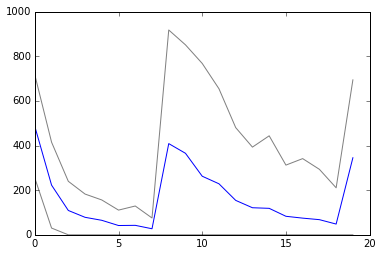

In [8]:
plt.plot(np.mean(lyap_avg_hist, axis=0))
plt.plot(np.mean(lyap_avg_hist, axis=0) + np.std(lyap_avg_hist, axis=0), 'gray')
plt.plot(np.maximum(np.mean(lyap_avg_hist, axis=0) - np.std(lyap_avg_hist, axis=0), np.zeros(20)), 'gray')